In [7]:
# Import TensorFlow and other necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pathlib
import random

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Rescaling
from keras.losses import SparseCategoricalCrossentropy

# Import for predictions
import os
from os import listdir

# Supressing warning messages on output
import warnings
warnings.filterwarnings("ignore")

Found 49780 files belonging to 2 classes.
Using 34846 files for training.
Found 49780 files belonging to 2 classes.
Using 14934 files for validation.
Epoch 1/10
545/545 [==============================] - 124s 220ms/step - loss: 0.2598 - accuracy: 0.8820 - val_loss: 0.1288 - val_accuracy: 0.9536
Epoch 2/10
545/545 [==============================] - 115s 211ms/step - loss: 0.1151 - accuracy: 0.9571 - val_loss: 0.1077 - val_accuracy: 0.9616
Epoch 3/10
545/545 [==============================] - 109s 199ms/step - loss: 0.0930 - accuracy: 0.9665 - val_loss: 0.0907 - val_accuracy: 0.9678
Epoch 4/10
545/545 [==============================] - 110s 201ms/step - loss: 0.0836 - accuracy: 0.9691 - val_loss: 0.1144 - val_accuracy: 0.9589
Epoch 5/10
545/545 [==============================] - 112s 206ms/step - loss: 0.0744 - accuracy: 0.9723 - val_loss: 0.0828 - val_accuracy: 0.9720
Epoch 6/10
545/545 [==============================] - 109s 201ms/step - loss: 0.0663 - accuracy: 0.9759 - val_loss: 0.11

INFO:tensorflow:Assets written to: model/trained_human_nonhuman/assets


INFO:tensorflow:Assets written to: model/trained_human_nonhuman/assets


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 128, 120, 1)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 128, 120, 16)      32        
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 64, 60, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 64, 60, 32)        544       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 32, 30, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 30, 64)       

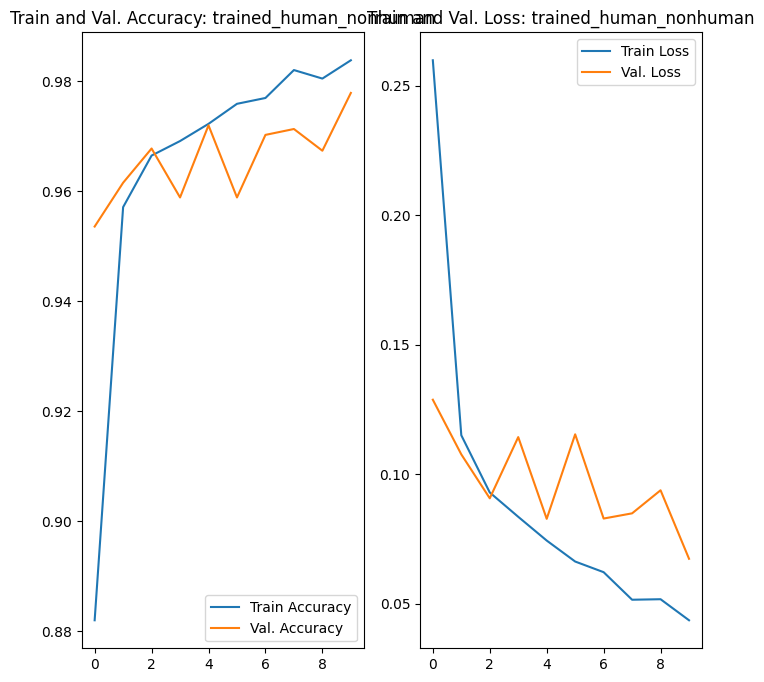

human1.jpg
1/1 [==============================] - 0s 105ms/step
human1.jpg most likely belongs to humans with a 98.82 percent confidence.
human2.png
1/1 [==============================] - 0s 22ms/step
human2.png most likely belongs to humans with a 100.00 percent confidence.
nh1.jpeg
1/1 [==============================] - 0s 22ms/step
nh1.jpeg most likely belongs to nonhumans with a 100.00 percent confidence.
nh2.jpeg
1/1 [==============================] - 0s 22ms/step
nh2.jpeg most likely belongs to nonhumans with a 100.00 percent confidence.
nh5.png
1/1 [==============================] - 0s 22ms/step
nh5.png most likely belongs to nonhumans with a 100.00 percent confidence.
human4.jpeg
1/1 [==============================] - 0s 23ms/step
human4.jpeg most likely belongs to nonhumans with a 100.00 percent confidence.
nh3.jpeg
1/1 [==============================] - 0s 21ms/step
nh3.jpeg most likely belongs to nonhumans with a 100.00 percent confidence.
nh4.jpeg
1/1 [=====================

INFO:tensorflow:Assets written to: model/trained_mask_nomask/assets


INFO:tensorflow:Assets written to: model/trained_mask_nomask/assets


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 128, 120, 1)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 128, 120, 16)      32        
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 64, 60, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 64, 60, 32)        544       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 32, 30, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 32, 30, 64)       

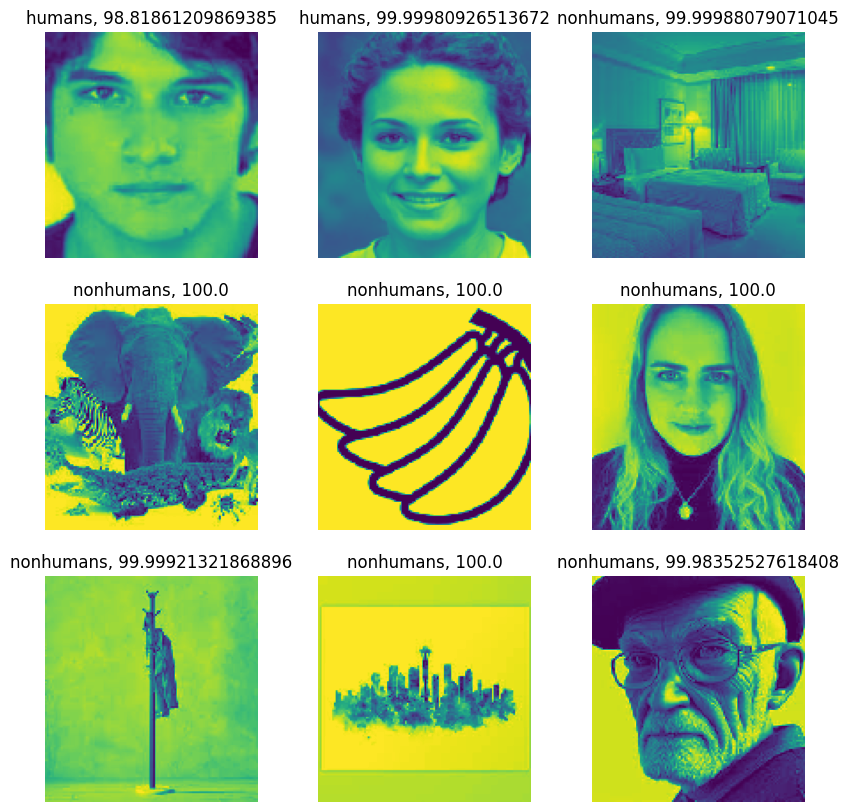

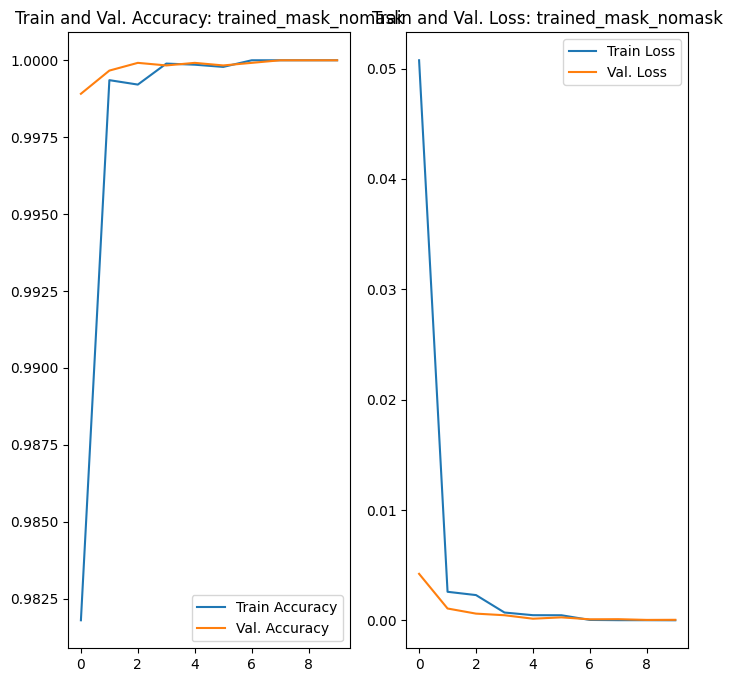

mask3.jpeg
1/1 [==============================] - 0s 113ms/step
mask3.jpeg most likely belongs to nomask with a 100.00 percent confidence.
mask2.jpeg
1/1 [==============================] - 0s 24ms/step
mask2.jpeg most likely belongs to nomask with a 100.00 percent confidence.
mask5.jpeg
1/1 [==============================] - 0s 24ms/step
mask5.jpeg most likely belongs to nomask with a 99.99 percent confidence.
mask4.jpeg
1/1 [==============================] - 0s 24ms/step
mask4.jpeg most likely belongs to mask with a 100.00 percent confidence.
mask7.png
1/1 [==============================] - 0s 27ms/step
mask7.png most likely belongs to mask with a 100.00 percent confidence.
nomask1.jpg
1/1 [==============================] - 0s 26ms/step
nomask1.jpg most likely belongs to nomask with a 100.00 percent confidence.
nomask2.png
1/1 [==============================] - 0s 25ms/step
nomask2.png most likely belongs to nomask with a 100.00 percent confidence.
mask1.png
1/1 [=====================

INFO:tensorflow:Assets written to: model/trained_glasses_noglasses/assets


INFO:tensorflow:Assets written to: model/trained_glasses_noglasses/assets


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 128, 120, 1)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 128, 120, 16)      32        
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 64, 60, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 64, 60, 32)        544       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 32, 30, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 32, 30, 64)       

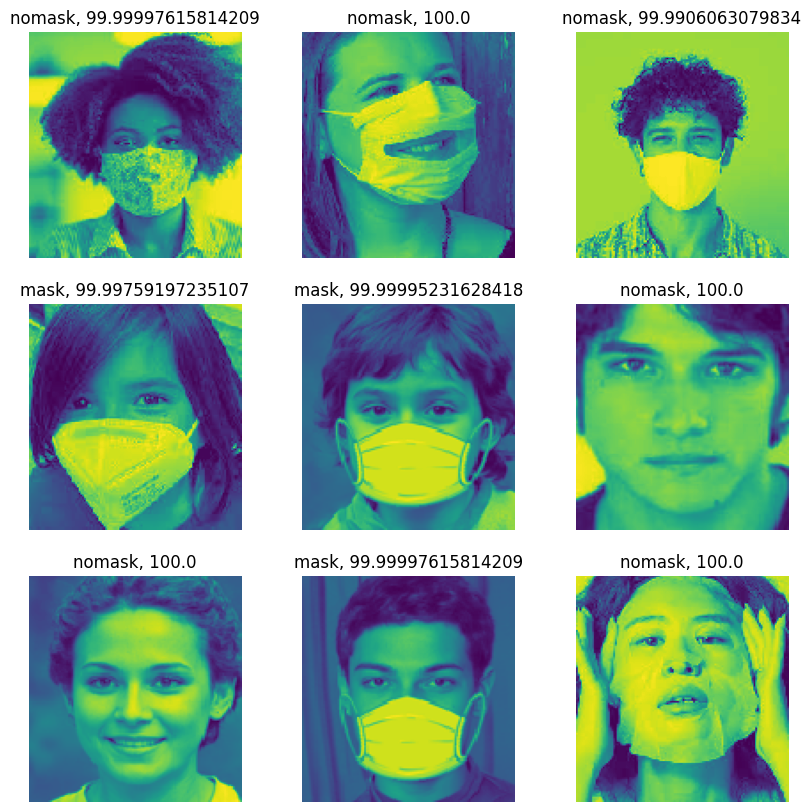

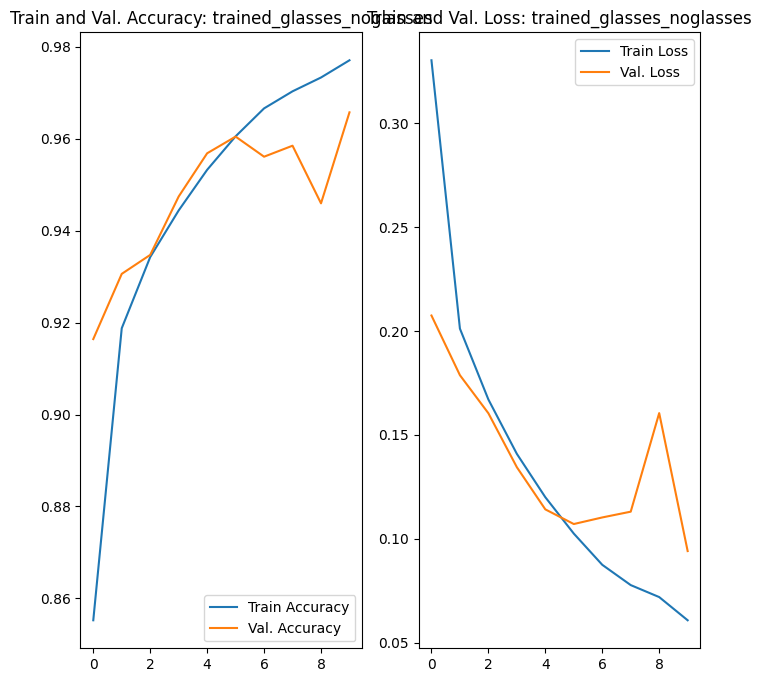

glasses5.jpeg
1/1 [==============================] - 0s 313ms/step
glasses5.jpeg most likely belongs to glasses with a 69.10 percent confidence.
glasses4.jpeg
1/1 [==============================] - 0s 67ms/step
glasses4.jpeg most likely belongs to glasses with a 99.92 percent confidence.
noglasses1.jpeg
1/1 [==============================] - 0s 73ms/step
noglasses1.jpeg most likely belongs to glasses with a 100.00 percent confidence.
glasses3.jpeg
1/1 [==============================] - 0s 107ms/step
glasses3.jpeg most likely belongs to glasses with a 100.00 percent confidence.
glasses2.jpeg
1/1 [==============================] - 0s 66ms/step
glasses2.jpeg most likely belongs to glasses with a 100.00 percent confidence.
glasses1.jpeg
1/1 [==============================] - 0s 66ms/step
glasses1.jpeg most likely belongs to noglasses with a 68.60 percent confidence.
noglasses4.jpeg
1/1 [==============================] - 0s 69ms/step
noglasses4.jpeg most likely belongs to glasses with a 100

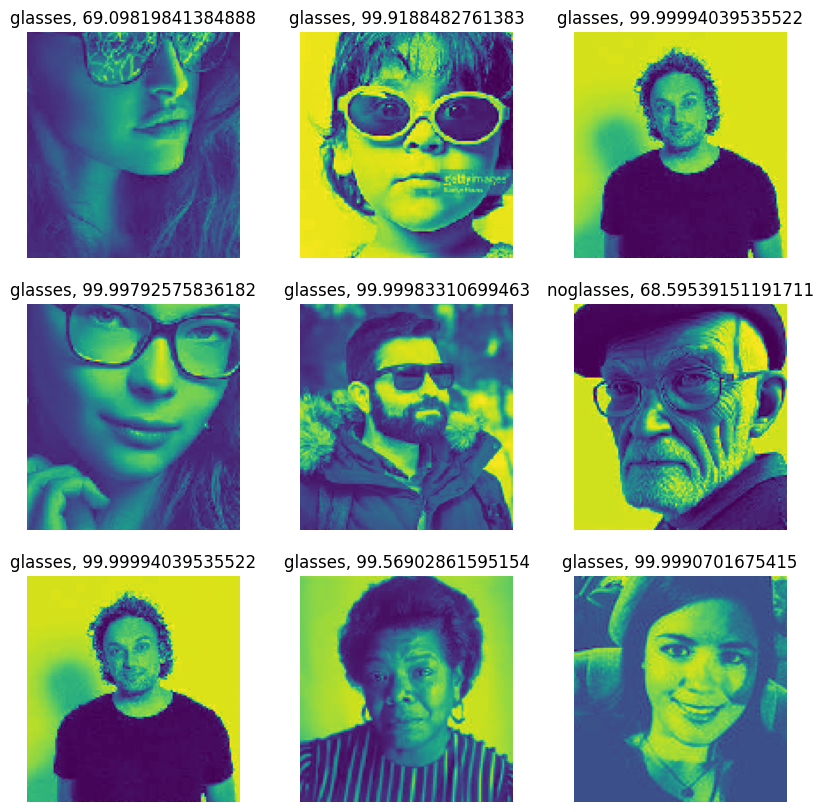

In [8]:

# Visualize the Training Results in Plot Data
def visualization_report(history, epochs, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val. Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'Train and Val. Accuracy: {model_name}')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val. Loss')
    plt.legend(loc='upper right')
    plt.title(f'Train and Val. Loss: {model_name}')
    plt.show()


def run_predictions(model, class_names, img_height, img_width, config):
    # Running Predictions on Images outside of Dataset in General
    pred_path = config["prediction_data_path"]
    plt.figure(figsize=(10, 10))
    figure_counter = 1

    for img_p in os.listdir(pred_path):
        if (img_p.endswith(".png")) or (img_p.endswith(".jpg")) or (img_p.endswith(".jpeg")):
            print(img_p)
            # Grayscale the image in the same way for prediction
            img_path = f'{pred_path}{img_p}'
            img = tf.keras.utils.load_img(
                img_path, color_mode='grayscale', target_size=(img_width, img_height), keep_aspect_ratio=True
            )

            plt.subplot(3, 3, figure_counter)
            plt.imshow(img)
            plt.axis("off")

            img_array = tf.keras.utils.img_to_array(img)
            img_array = tf.expand_dims(img_array, 0)  # Create a batch

            predictions = model.predict(img_array)
            score = tf.nn.softmax(predictions[0])

            result_msg = f'{class_names[np.argmax(score)]}, {100 * np.max(score)}'
            plt.title(result_msg)
            print(
                "{} most likely belongs to {} with a {:.2f} percent confidence."
                .format(img_p, class_names[np.argmax(score)], 100 * np.max(score))
            )

            figure_counter += 1

def train_keras_model(config={}):

    # Requires Config
    if not bool(config):
        return None

    # Image Loader Params
    shape_size  = 1
    dataset_url = config["dataset_path"]
    batch_size  = config["batch_size"]
    batch_seed  = config["batch_seed"]
    img_height  = config["img_height"]
    img_width   = config["img_width"]
    img_shape   = (img_width, img_height)
    input_shape = (img_width, img_height, shape_size)

    tf_autotune = tf.data.AUTOTUNE
    data_dir = pathlib.Path(dataset_url)

    # Train Split at 70%
    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.3,
        subset="training",
        image_size=img_shape,
        seed=batch_seed,
        color_mode='grayscale',
        batch_size=batch_size)

    # Validation of the data at 70%
    val_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.3,
        subset="validation",
        image_size=img_shape,
        seed=batch_seed,
        color_mode='grayscale',
        batch_size=batch_size)
    
    # Classification of names - each image type in its own dir
    class_names = train_ds.class_names
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf_autotune)
    val_ds = val_ds.cache().prefetch(buffer_size=tf_autotune)

    # Create basic Keras Model

    # The Keras Sequential model consists of three convolution blocks(tf.keras.layers.Conv2D)
    # with a max pooling layer(tf.keras.layers.MaxPooling2D) in each of them.
    #
    # There's a fully-connected layer (tf.keras.layers.Dense) with 128 units on top of it that
    # is activated by a ReLU activation function ('relu').
    #
    # This model has not been tuned for high accuracy; the goal of this tutorial is to show a standard approach.


    num_classes = len(class_names)
    model_save_path = config["model_save_path"]
    model_save_name = config["model_save_name"]
    epochs = config["epochs"]

    # try:
    # model = keras.models.load_model(model_save_path)
    # history = model.history
    # except OSError:
    model = Sequential([
        Rescaling(1./255, input_shape=input_shape),
        Conv2D(16, shape_size, activation='relu',
               padding='same', input_shape=input_shape),
        MaxPooling2D(),
        Conv2D(32, shape_size, activation='relu',
               padding='same', input_shape=input_shape),
        MaxPooling2D(),
        Conv2D(64, shape_size, activation='relu',
               padding='same', input_shape=input_shape),
        MaxPooling2D(),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes)
    ])

    # Compile the model

    # For this tutorial, choose the tf.keras.optimizers.Adam optimizer and
    # tf.keras.losses.SparseCategoricalCrossentropy loss function.
    #
    # To view training and validation accuracy for each training epoch, pass the metrics argument to Model.compile.
    model.compile(optimizer='adam',
                loss=SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs
    )

    model.save(model_save_path)
    print(f'Model Summary: {model_save_name}', model.summary())
    
    visualization_report(history, epochs, model_save_name)
    run_predictions(model, class_names, img_height, img_width, config)

# All different types of config to be generated
def generate_configs(model_type):
    # Generate configs by model type/name
    return {
        "dataset_path": f'data/training_{model_type}/',
        "model_save_path": f'model/trained_{model_type}',
        "model_save_name": f'trained_{model_type}',
        "prediction_data_path": f'data/predictions/{model_type}/',
        "epochs": 10,
        "batch_size": 64,
        "batch_seed": random.randint(1, 581),
        "img_height": 120,
        "img_width": 128
    }


# Human vs. Nonhuman Configurations
config_human_nonhuman = generate_configs("human_nonhuman")

# Mask vs. No Mask Configurations
config_mask_nomask = generate_configs("mask_nomask")

# Glasses vs No Glasses Configurations
config_glasses_noglasses = generate_configs("glasses_noglasses")

train_keras_model(config_human_nonhuman)
train_keras_model(config_mask_nomask)
train_keras_model(config_glasses_noglasses)
